In [1]:
import numpy as np
import torch, sys
from torchvision.transforms import functional as func
import torchvision.transforms as transforms
from loss import ComputeLoss
import yaml, random
import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone import ViewField as F
from new_model import Model
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import NullLocator
from torch.utils.data import DataLoader

from dataloader import FiftyOneTorchDataset
from util import non_max_suppression


In [2]:
dataset_train = foz.load_zoo_dataset(
    "coco-2017",
    split="train",
    # label_types=[""],
    classes=["cat", "dog"],
    max_samples=1,
)

Found annotations at '/home/rohit/fiftyone/coco-2017/raw/instances_train2017.json'
Sufficient images already downloaded
Existing download of split 'train' is sufficient
Loading existing dataset 'coco-2017-train-1'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [3]:

dataset_validation = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    # label_types=[""],
    classes=["cat", "dog"],
    max_samples=1,
)

Found annotations at '/home/rohit/fiftyone/coco-2017/raw/instances_val2017.json'
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'coco-2017-validation-1'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [4]:

dataset_train.persistent = True
dataset_validation.persistent = True
view_train = dataset_train.filter_labels("ground_truth", F("label").is_in(("cat", "dog")))
view_val = dataset_validation.filter_labels("ground_truth", F("label").is_in(("cat", "dog")))
view_train = view_train.take(1, seed=61)
view_val = view_val.take(1, seed=61)

fil_classes = ["cat", "dog"]
device = torch.device('cuda:0')

with open("hyp.yaml", "r") as stream:
    try:
        hyp = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)


org_w = 640
org_h = 480
scaling_factor = 640/480

batch_size = 1

transform = transforms.Compose([transforms.Resize((int(org_h/scaling_factor), int(org_w/scaling_factor))),
                                transforms.Pad((0, int((org_w - org_h)/(2*scaling_factor)),0,int((org_w - org_h)/(2*scaling_factor)))),
                                transforms.ToTensor()])
            
dataset_train = FiftyOneTorchDataset(view_train, transform, classes=fil_classes)
dataset_val = FiftyOneTorchDataset(view_val, transform, classes=fil_classes)
loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=True)



In [5]:

model = Model('yolov3.yaml', hyp=hyp).to(device)

optimizer = torch.optim.Adam(model.parameters(),1e-3)
loss_fcn = ComputeLoss(model)
#training
train_loss_list = []
val_loss_list = []
# Add predictions to samples\
epochs = 500
for epoch in range(epochs):
    #training
    tot_loss = 0
    count = 0
    for images, targets in loader_train:
        model.train()
        optimizer.zero_grad()
        images = images.to(device)
        targets = targets.to(device)
        preds = model(images)
        loss, loss_parts = loss_fcn(preds, targets)
        tot_loss += loss / batch_size
        count += 1
        loss.backward()
        optimizer.step()
        
    #save the model each 50 epochs
    # if epoch%50==0 and epoch!=0:
    #     torch.save(model,'./models/model'+str(epoch)+'.pt')
    print(epoch, 'Training:\t',epoch, tot_loss.item()/count)
    train_loss_list.append(tot_loss.item()/count)
    
    #validation
    tot_loss = 0
    count = 0
    for images, targets in loader_val:
        images = images.to(device)
        targets = targets.to(device)
        with torch.no_grad():
            preds = model(images)
            loss, loss_parts = loss_fcn(preds, targets)
            tot_loss += loss / batch_size
        count += 1
    print('\tValidation:\t', tot_loss.item()/count)
    val_loss_list.append(tot_loss.item()/count)

torch.save(model,'./models/final'+'.pt')    

from util import my_load,my_save
my_save('trainloss',train_loss_list)
my_save('validationloss',val_loss_list)

#  TODO: val code, val dataloader, save model, save training loss



0 Training:	 0 0.18305248022079468
	Validation:	 0.11308266222476959
1 Training:	 1 0.1464347094297409
	Validation:	 0.11359642446041107
2 Training:	 2 0.13498453795909882
	Validation:	 0.11150562018156052
3 Training:	 3 0.12062499672174454
	Validation:	 0.11058760434389114
4 Training:	 4 0.11415944248437881
	Validation:	 0.11132265627384186
5 Training:	 5 0.11192693561315536
	Validation:	 0.10940394550561905
6 Training:	 6 0.11017913371324539
	Validation:	 0.10856807231903076
7 Training:	 7 0.10888903588056564
	Validation:	 0.10820464789867401
8 Training:	 8 0.10729478299617767
	Validation:	 0.10831154137849808
9 Training:	 9 0.10603129118680954
	Validation:	 0.10841858386993408
10 Training:	 10 0.10496950894594193
	Validation:	 0.10799399763345718
11 Training:	 11 0.10346807539463043
	Validation:	 0.10753121972084045
12 Training:	 12 0.10125641524791718
	Validation:	 0.10781882703304291
13 Training:	 13 0.10274360328912735
	Validation:	 0.10748288035392761
14 Training:	 14 0.10222341

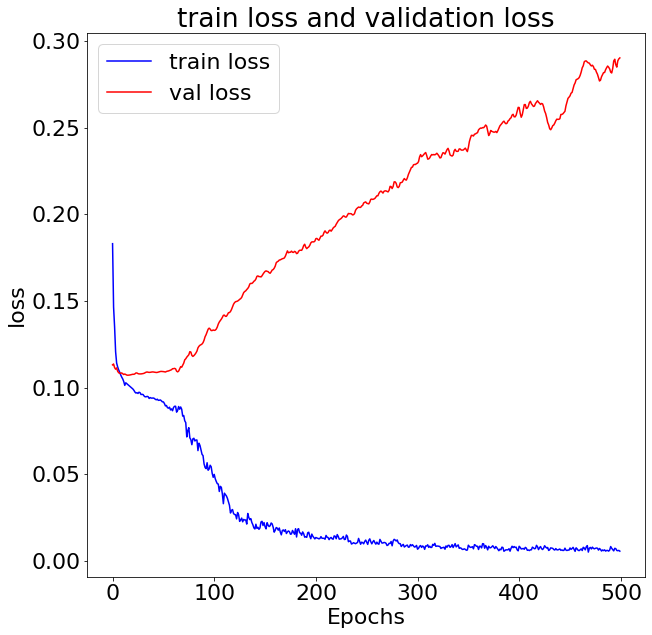

In [6]:
from util import plot
plot(train_loss_list,val_loss_list,'train loss','val loss','loss','train loss and validation loss')

In [7]:
from util import my_img_plot
import gc
gc.collect() 
torch.cuda.empty_cache()
device = torch.device('cuda:0')
model = torch.load('./models/final.pt').to(device)




1
torch.Size([1, 14175, 85])
torch.Size([3, 480, 480])
	+ Label: dog | Confidence: 0.9855
	+ Label: dog | Confidence: 0.9464


<Figure size 432x288 with 0 Axes>

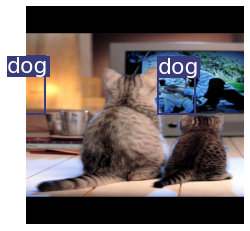

In [9]:

model.eval()
for images, targets in loader_train:
    # for image in images:
    images = images.to(device)
    with torch.no_grad():
        pred = model(images)[0]
        print(len(pred))
        print(pred.shape)
        print(images[0].shape)
        my_img_plot(pred,images[0],fil_classes,1)
    # break